# Search-based Fuzzing

Sometimes we are not only interested in fuzzing as many as possible diverse program inputs, but in deriving *specific* test inputs that achieve some objective, such as reaching specific statements in a program. When we have an idea of what we are looking for, then we can *search* for it. Search algorithms are at the core of computer science, but applying classic search algorithms like breadth or depth first search to search for tests is unrealistic, because these algorithms potentially require us to look at all possible inputs. However, domain-knowledge can be used to overcome this problem. For example, if we can estimate which of several program inputs is closer to the one we are looking for, then this information can guide us to reach the target quicker -- this information is known as a *heuristic*. The way heuristics are applied systematically is captured in *meta-heuristic* search algorithms. The "meta" denotes that these algorithm are generic and can be instantiated differently to different problems. Meta-heuristics often take inspiration from processes observed in nature. For example, there are algorithms mimicking evolutionary processes, swarm intelligence, or chemical reactions. In general they are much more efficient than exhaustive search approaches such that they can be applied to vast search spaces --- search spaces as vast as the domain of program inputs are no problem for them.

**Prerequisites**

* You should know how code coverage works, e.g. from the [chapter on coverage](Coverage.ipynb).

## Test Generation as a Search Problem

If we want to apply a meta-heuristic search algorithm to generate test data for a program, then we have to make several choices: First, we need to decide on what exactly our *search space* is in the first place. The search space is defined by how we *represent* what we are looking for. Are we looking for single integer values? Tuples of values? Objects? XML documents? 

### Representing program inputs as a search problem

The representation is highly dependent on the particular testing problem we are solving --- we know which program we are testing, so the representation needs to encode whatever an input to our target program is. Let's consider the example function `testMe` as our function under test: 

In [3]:
def test_me(x, y):
    if x == 2 * (y + 1):
        return True 
    else:
        return False

The `test_me` function has two input parameters, and returns `True` or `False` depending on how the two relate to each other. A test input to `test_me` consists of a pair of values, one for `x` and one for `y`. For example:

In [33]:
print(test_me(0, 0))
print(test_me(4, 2))
print(test_me(22, 10))

False
False
True


Our search space is only concerned with inputs, thus a simple representation for test data would be input tuples `(x, y)`. Each point in this input space has eight *neighbours*:

- `x-1, y-1`
- `x-1, y`
- `x-1, y+1`
- `x, y+1`
- `x+1, y+1`
- `x+1, y`
- `x, y-1`

To keep things simple, let's restrict the size of our search space to start with (we will change this later). For example, let's assume we only want values in the range of -10000 to 10000:

In [13]:
MIN=-10000
MAX=10000

To retrieve the neighbours for any point in our search space, we define the function `neighbours`:

In [32]:
def neighbours(x, y):
    return [(x+dx, y+dy) for dx in [-1,0,1] \
                         for dy in [-1,0,1] \
                         if (dx != 0 or dy != 0)\
                            and ((MIN <= x+dx <= MAX) \
                            and (MIN <= y+dy <= MAX))]

In [16]:
print(neighbours(10, 10))

[(9, 9), (9, 10), (9, 11), (10, 9), (10, 11), (11, 9), (11, 10), (11, 11)]


This fully defines our search space: We have a representation, and we know how individuals are related to each other through their neighbourhood. Now we just need to find an algorithm to explore this neighbourhood.

### Defining a search landscape: Fitness functions

All meta-heuristics are based on the use of a heuristic function that estimates how good a given candidate solution is; this "goodness" is typically called the *fitness* of an individual, and the heuristic that estimates the fitness is the *fitness function*. The fitness function is a function that maps any point in the search space to a numerical value, the fitness value. If you plot each point in the search space with its fitness value as the height, you get a landscape with the optimal solution represented as the highest peak.

The fitness function depends on the objective one would like to achieve with generating the test data. Suppose that we are interested in covering the true branch of the if-condition in the `test_me` function, i.e. `x == 2 * (y + 1)`.

How close is a given input tuple for this function from reaching the target branch? Let's consider an arbitrary point in the search space, e.g. `(274, 153)`. The if-condition compares the following values:

In [17]:
x = 274
y = 153
print(x)
print(2 * (y + 1))

274
308


In order to make the branch true, both values need to be the same. Thus, the more they differ, the further we are away from making the comparison true, and the less they differ, the closer we are from making the comparison true. Thus, we can quantify "how false" the comparison is by calculating the difference between `x` and `2 * (y + 1)`. Thus, we can calculate this distance as `abs(x - 2 * (y + 1))`:

In [5]:
def calculate_distance(x, y):
    return abs(x - 2 * (y + 1))

print(calculate_distance(274, 153))

34


For each value in the search space of integer tuples, this distance value defines the elevation in our search landscape. Since our example search space is two-dimensional, the search landscape is three-dimensional and we can plot it to see what it looks like:

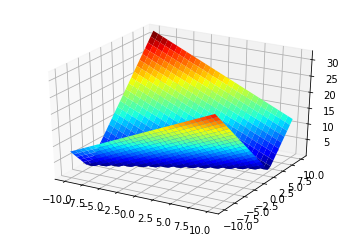

In [36]:
from mpl_toolkits.mplot3d import Axes3D

x = np.outer(np.linspace(-10, 10, 30), np.ones(30))
y = x.copy().T
z = calculate_distance(x, y)

fig = plt.figure()
ax = plt.axes(projection='3d')

ax.plot_surface(x, y, z, cmap=plt.cm.jet, rstride=1, cstride=1, linewidth=0)


The optimal values, i.e. those that make the if-condition true, have fitness value 0 and can be clearly seen at the bottom of the plot. The further away from the optimal values, the higher elevated the points in the search space.

### Instrumentation

The fitness function should calculate the distance value for concrete test executions. That is, we want to run the program, and then learn the distance value of this execution. However, the branching condition is hidden within the source code of the target function, and its value may in principle be the result of various calculations along the execution path reaching it. Even though in our example the condition is an equation using the input values of the function directly, this may not be the case in general; it might as well be derived values. Thus, the values we need to calculate our distance metric need to be observed directly at the conditional statement.

This is typically done with *instrumentation*: We add new code immediately before or after the branching condition to keep track of the values observed and calculate the distance using these values. The following is an instrumented version of our program under test, which prints out the distance values as it is executed:

In [6]:
def test_me_instrumented(x, y):
    
    print("Instrumentation: Input = (%d, %d), distance = %d" % (x, y, calculate_distance(x,y)))
    if x == 2*(y+1):
        return True 
    else:
        return False

Let's try this out for a couple of example values:

In [48]:
test_me_instrumented(0, 0)
test_me_instrumented(5, 2)
test_me_instrumented(22, 10)

Instrumentation: Input = (0, 0), distance = 2
Instrumentation: Input = (5, 2), distance = 1
Instrumentation: Input = (22, 10), distance = 0


True

When calculating a fitness value, we will execute the instrumented program version, but we need some means to access the distance value calculated during that execution. As a simple first solution to this problem, we can simply add a global variable and store the value of the distance calculation there. 

In [7]:
distance = 0
def test_me_instrumented(x, y):
    global distance
    distance = calculate_distance(x, y)
    if x == 2*(y+1):
        return True 
    else:
        return False

Using this instrumented version of `test_me`, we can now finally define our fitness function, which simply runs the instrumented `test_me_instrumented` function, and then retrieves the value of the global `distance` variable:

In [8]:
def get_fitness(x, y):
    global distance
    test_me_instrumented(x, y)
    fitness = distance
    return fitness

Let's try this on some example inputs:

In [67]:
print("Fitness of (0, 0)  = %d" % get_fitness(0, 0))
print("Fitness of (1, 2)  = %d" % get_fitness(1, 2))
print("Fitness of (22,10) = %d" % get_fitness(22,10))

Fitness of (0, 0)  = 2
Fitness of (1, 2)  = 5
Fitness of (22,10) = 0


### Hillclimbing the example

Having decided on a representation (2-tuples of integers) and a fitness function (distance to target branch), we can now finally go ahead and implement our search algorithm. Let's explore this search space using the simplest possible meta-heuristic algorithm: Hillclimbing. The metaphor captures aptly what is happening: The algorithm tries to climb a hill in the search space defined by our representation. Except, that in our search landscape the best values are not those high up but down low, so technically we are are descending into valleys.

The hillclimbing algorithm itself is very simple: 
1. Take a random starting point
2. Determine fitness value of all neighbours
3. Move to neighbour with the best fitness value
4. If solution is not found, continue with step 2

The hillclimber starts with a random test input, i.e., random values for `x` and `y`. For any pair of random integer numbers, the chances of them satisfying the condition `x == 2 * (y + 1)` are rather slim. Suppose the random values are `(274, 153)`. The right hand side of the equation, `2 * (y + 1)`, evaluates to 308, so the condition is clearly false. Where should the hillclimber go to now? Let's look at the fitness values of this test input and its neighbours:

In [77]:
x, y = 274, 153
print("%d, %d: %d" % (x, y, get_fitness(x, y)))
for nx, ny in neighbours(x, y):
    print("%d, %d: %d" % (nx, ny, get_fitness(nx, ny)))

274, 153: 34
273, 152: 33
273, 153: 35
273, 154: 37
274, 152: 32
274, 154: 36
275, 152: 31
275, 153: 33
275, 154: 35


Increasing `y` by one increases the value of the right hand side of the equation to `310`. Thus, the value on the left hand side of the equation thus differs *even more* to the value on the right hand side of the equation than it did before the increase! So, increasing `y` does not seem like a good idea. On the other hand, increasing `x` by one improves things: The left hand side and the right hand side of the equation become more similar; they are "less unequal". Thus, out of the eight possible neighbors of `(274, 153)`, the neighbor that increases `x` and decreases `y` (`(275, 152)`) seems best intuitively --- the outcome of the condition is still false, but it is "less so" than for the original value.

Let's now implement the hillcimbing algorithm. 

In [9]:
import random

def hillclimber():
    # Create and evaluate starting point
    x, y = random.randint(MIN, MAX), random.randint(MIN, MAX)
    fitness = get_fitness(x, y)
    print("Initial value: %d, %d at fitness %.4f" %(x, y, fitness))
    iterations = 0
    
    # Stop once we have found an optimal solution
    while fitness > 0:
        iterations += 1
        # Move to first neighbour with a better fitness 
        for (nextx, nexty) in neighbours(x,y):
            new_fitness = get_fitness(nextx, nexty)
            if new_fitness < fitness:
                x, y = nextx, nexty
                fitness = new_fitness
                print("New value: %d, %d at fitness %.4f" %(x, y, fitness))
                break

    print("Found optimum after %d iterations at %d, %d" % (iterations, x, y))
    
hillclimber()

Initial value: 4088, -7089 at fitness 18264.0000
New value: 4087, -7089 at fitness 18263.0000
New value: 4086, -7089 at fitness 18262.0000
New value: 4085, -7089 at fitness 18261.0000
New value: 4084, -7089 at fitness 18260.0000
New value: 4083, -7089 at fitness 18259.0000
New value: 4082, -7089 at fitness 18258.0000
New value: 4081, -7089 at fitness 18257.0000
New value: 4080, -7089 at fitness 18256.0000
New value: 4079, -7089 at fitness 18255.0000
New value: 4078, -7089 at fitness 18254.0000
New value: 4077, -7089 at fitness 18253.0000
New value: 4076, -7089 at fitness 18252.0000
New value: 4075, -7089 at fitness 18251.0000
New value: 4074, -7089 at fitness 18250.0000
New value: 4073, -7089 at fitness 18249.0000
New value: 4072, -7089 at fitness 18248.0000
New value: 4071, -7089 at fitness 18247.0000
New value: 4070, -7089 at fitness 18246.0000
New value: 4069, -7089 at fitness 18245.0000
New value: 4068, -7089 at fitness 18244.0000
New value: 4067, -7089 at fitness 18243.0000
New va

New value: 2862, -7089 at fitness 17038.0000
New value: 2861, -7089 at fitness 17037.0000
New value: 2860, -7089 at fitness 17036.0000
New value: 2859, -7089 at fitness 17035.0000
New value: 2858, -7089 at fitness 17034.0000
New value: 2857, -7089 at fitness 17033.0000
New value: 2856, -7089 at fitness 17032.0000
New value: 2855, -7089 at fitness 17031.0000
New value: 2854, -7089 at fitness 17030.0000
New value: 2853, -7089 at fitness 17029.0000
New value: 2852, -7089 at fitness 17028.0000
New value: 2851, -7089 at fitness 17027.0000
New value: 2850, -7089 at fitness 17026.0000
New value: 2849, -7089 at fitness 17025.0000
New value: 2848, -7089 at fitness 17024.0000
New value: 2847, -7089 at fitness 17023.0000
New value: 2846, -7089 at fitness 17022.0000
New value: 2845, -7089 at fitness 17021.0000
New value: 2844, -7089 at fitness 17020.0000
New value: 2843, -7089 at fitness 17019.0000
New value: 2842, -7089 at fitness 17018.0000
New value: 2841, -7089 at fitness 17017.0000
New value:

New value: 1780, -7089 at fitness 15956.0000
New value: 1779, -7089 at fitness 15955.0000
New value: 1778, -7089 at fitness 15954.0000
New value: 1777, -7089 at fitness 15953.0000
New value: 1776, -7089 at fitness 15952.0000
New value: 1775, -7089 at fitness 15951.0000
New value: 1774, -7089 at fitness 15950.0000
New value: 1773, -7089 at fitness 15949.0000
New value: 1772, -7089 at fitness 15948.0000
New value: 1771, -7089 at fitness 15947.0000
New value: 1770, -7089 at fitness 15946.0000
New value: 1769, -7089 at fitness 15945.0000
New value: 1768, -7089 at fitness 15944.0000
New value: 1767, -7089 at fitness 15943.0000
New value: 1766, -7089 at fitness 15942.0000
New value: 1765, -7089 at fitness 15941.0000
New value: 1764, -7089 at fitness 15940.0000
New value: 1763, -7089 at fitness 15939.0000
New value: 1762, -7089 at fitness 15938.0000
New value: 1761, -7089 at fitness 15937.0000
New value: 1760, -7089 at fitness 15936.0000
New value: 1759, -7089 at fitness 15935.0000
New value:

New value: 581, -7089 at fitness 14757.0000
New value: 580, -7089 at fitness 14756.0000
New value: 579, -7089 at fitness 14755.0000
New value: 578, -7089 at fitness 14754.0000
New value: 577, -7089 at fitness 14753.0000
New value: 576, -7089 at fitness 14752.0000
New value: 575, -7089 at fitness 14751.0000
New value: 574, -7089 at fitness 14750.0000
New value: 573, -7089 at fitness 14749.0000
New value: 572, -7089 at fitness 14748.0000
New value: 571, -7089 at fitness 14747.0000
New value: 570, -7089 at fitness 14746.0000
New value: 569, -7089 at fitness 14745.0000
New value: 568, -7089 at fitness 14744.0000
New value: 567, -7089 at fitness 14743.0000
New value: 566, -7089 at fitness 14742.0000
New value: 565, -7089 at fitness 14741.0000
New value: 564, -7089 at fitness 14740.0000
New value: 563, -7089 at fitness 14739.0000
New value: 562, -7089 at fitness 14738.0000
New value: 561, -7089 at fitness 14737.0000
New value: 560, -7089 at fitness 14736.0000
New value: 559, -7089 at fitness

New value: -637, -7089 at fitness 13539.0000
New value: -638, -7089 at fitness 13538.0000
New value: -639, -7089 at fitness 13537.0000
New value: -640, -7089 at fitness 13536.0000
New value: -641, -7089 at fitness 13535.0000
New value: -642, -7089 at fitness 13534.0000
New value: -643, -7089 at fitness 13533.0000
New value: -644, -7089 at fitness 13532.0000
New value: -645, -7089 at fitness 13531.0000
New value: -646, -7089 at fitness 13530.0000
New value: -647, -7089 at fitness 13529.0000
New value: -648, -7089 at fitness 13528.0000
New value: -649, -7089 at fitness 13527.0000
New value: -650, -7089 at fitness 13526.0000
New value: -651, -7089 at fitness 13525.0000
New value: -652, -7089 at fitness 13524.0000
New value: -653, -7089 at fitness 13523.0000
New value: -654, -7089 at fitness 13522.0000
New value: -655, -7089 at fitness 13521.0000
New value: -656, -7089 at fitness 13520.0000
New value: -657, -7089 at fitness 13519.0000
New value: -658, -7089 at fitness 13518.0000
New value:

New value: -1852, -7089 at fitness 12324.0000
New value: -1853, -7089 at fitness 12323.0000
New value: -1854, -7089 at fitness 12322.0000
New value: -1855, -7089 at fitness 12321.0000
New value: -1856, -7089 at fitness 12320.0000
New value: -1857, -7089 at fitness 12319.0000
New value: -1858, -7089 at fitness 12318.0000
New value: -1859, -7089 at fitness 12317.0000
New value: -1860, -7089 at fitness 12316.0000
New value: -1861, -7089 at fitness 12315.0000
New value: -1862, -7089 at fitness 12314.0000
New value: -1863, -7089 at fitness 12313.0000
New value: -1864, -7089 at fitness 12312.0000
New value: -1865, -7089 at fitness 12311.0000
New value: -1866, -7089 at fitness 12310.0000
New value: -1867, -7089 at fitness 12309.0000
New value: -1868, -7089 at fitness 12308.0000
New value: -1869, -7089 at fitness 12307.0000
New value: -1870, -7089 at fitness 12306.0000
New value: -1871, -7089 at fitness 12305.0000
New value: -1872, -7089 at fitness 12304.0000
New value: -1873, -7089 at fitness

New value: -2900, -7089 at fitness 11276.0000
New value: -2901, -7089 at fitness 11275.0000
New value: -2902, -7089 at fitness 11274.0000
New value: -2903, -7089 at fitness 11273.0000
New value: -2904, -7089 at fitness 11272.0000
New value: -2905, -7089 at fitness 11271.0000
New value: -2906, -7089 at fitness 11270.0000
New value: -2907, -7089 at fitness 11269.0000
New value: -2908, -7089 at fitness 11268.0000
New value: -2909, -7089 at fitness 11267.0000
New value: -2910, -7089 at fitness 11266.0000
New value: -2911, -7089 at fitness 11265.0000
New value: -2912, -7089 at fitness 11264.0000
New value: -2913, -7089 at fitness 11263.0000
New value: -2914, -7089 at fitness 11262.0000
New value: -2915, -7089 at fitness 11261.0000
New value: -2916, -7089 at fitness 11260.0000
New value: -2917, -7089 at fitness 11259.0000
New value: -2918, -7089 at fitness 11258.0000
New value: -2919, -7089 at fitness 11257.0000
New value: -2920, -7089 at fitness 11256.0000
New value: -2921, -7089 at fitness

New value: -4135, -7089 at fitness 10041.0000
New value: -4136, -7089 at fitness 10040.0000
New value: -4137, -7089 at fitness 10039.0000
New value: -4138, -7089 at fitness 10038.0000
New value: -4139, -7089 at fitness 10037.0000
New value: -4140, -7089 at fitness 10036.0000
New value: -4141, -7089 at fitness 10035.0000
New value: -4142, -7089 at fitness 10034.0000
New value: -4143, -7089 at fitness 10033.0000
New value: -4144, -7089 at fitness 10032.0000
New value: -4145, -7089 at fitness 10031.0000
New value: -4146, -7089 at fitness 10030.0000
New value: -4147, -7089 at fitness 10029.0000
New value: -4148, -7089 at fitness 10028.0000
New value: -4149, -7089 at fitness 10027.0000
New value: -4150, -7089 at fitness 10026.0000
New value: -4151, -7089 at fitness 10025.0000
New value: -4152, -7089 at fitness 10024.0000
New value: -4153, -7089 at fitness 10023.0000
New value: -4154, -7089 at fitness 10022.0000
New value: -4155, -7089 at fitness 10021.0000
New value: -4156, -7089 at fitness

New value: -5635, -7089 at fitness 8541.0000
New value: -5636, -7089 at fitness 8540.0000
New value: -5637, -7089 at fitness 8539.0000
New value: -5638, -7089 at fitness 8538.0000
New value: -5639, -7089 at fitness 8537.0000
New value: -5640, -7089 at fitness 8536.0000
New value: -5641, -7089 at fitness 8535.0000
New value: -5642, -7089 at fitness 8534.0000
New value: -5643, -7089 at fitness 8533.0000
New value: -5644, -7089 at fitness 8532.0000
New value: -5645, -7089 at fitness 8531.0000
New value: -5646, -7089 at fitness 8530.0000
New value: -5647, -7089 at fitness 8529.0000
New value: -5648, -7089 at fitness 8528.0000
New value: -5649, -7089 at fitness 8527.0000
New value: -5650, -7089 at fitness 8526.0000
New value: -5651, -7089 at fitness 8525.0000
New value: -5652, -7089 at fitness 8524.0000
New value: -5653, -7089 at fitness 8523.0000
New value: -5654, -7089 at fitness 8522.0000
New value: -5655, -7089 at fitness 8521.0000
New value: -5656, -7089 at fitness 8520.0000
New value:

New value: -7134, -7089 at fitness 7042.0000
New value: -7135, -7089 at fitness 7041.0000
New value: -7136, -7089 at fitness 7040.0000
New value: -7137, -7089 at fitness 7039.0000
New value: -7138, -7089 at fitness 7038.0000
New value: -7139, -7089 at fitness 7037.0000
New value: -7140, -7089 at fitness 7036.0000
New value: -7141, -7089 at fitness 7035.0000
New value: -7142, -7089 at fitness 7034.0000
New value: -7143, -7089 at fitness 7033.0000
New value: -7144, -7089 at fitness 7032.0000
New value: -7145, -7089 at fitness 7031.0000
New value: -7146, -7089 at fitness 7030.0000
New value: -7147, -7089 at fitness 7029.0000
New value: -7148, -7089 at fitness 7028.0000
New value: -7149, -7089 at fitness 7027.0000
New value: -7150, -7089 at fitness 7026.0000
New value: -7151, -7089 at fitness 7025.0000
New value: -7152, -7089 at fitness 7024.0000
New value: -7153, -7089 at fitness 7023.0000
New value: -7154, -7089 at fitness 7022.0000
New value: -7155, -7089 at fitness 7021.0000
New value:

New value: -8597, -7089 at fitness 5579.0000
New value: -8598, -7089 at fitness 5578.0000
New value: -8599, -7089 at fitness 5577.0000
New value: -8600, -7089 at fitness 5576.0000
New value: -8601, -7089 at fitness 5575.0000
New value: -8602, -7089 at fitness 5574.0000
New value: -8603, -7089 at fitness 5573.0000
New value: -8604, -7089 at fitness 5572.0000
New value: -8605, -7089 at fitness 5571.0000
New value: -8606, -7089 at fitness 5570.0000
New value: -8607, -7089 at fitness 5569.0000
New value: -8608, -7089 at fitness 5568.0000
New value: -8609, -7089 at fitness 5567.0000
New value: -8610, -7089 at fitness 5566.0000
New value: -8611, -7089 at fitness 5565.0000
New value: -8612, -7089 at fitness 5564.0000
New value: -8613, -7089 at fitness 5563.0000
New value: -8614, -7089 at fitness 5562.0000
New value: -8615, -7089 at fitness 5561.0000
New value: -8616, -7089 at fitness 5560.0000
New value: -8617, -7089 at fitness 5559.0000
New value: -8618, -7089 at fitness 5558.0000
New value:

New value: -9633, -7089 at fitness 4543.0000
New value: -9634, -7089 at fitness 4542.0000
New value: -9635, -7089 at fitness 4541.0000
New value: -9636, -7089 at fitness 4540.0000
New value: -9637, -7089 at fitness 4539.0000
New value: -9638, -7089 at fitness 4538.0000
New value: -9639, -7089 at fitness 4537.0000
New value: -9640, -7089 at fitness 4536.0000
New value: -9641, -7089 at fitness 4535.0000
New value: -9642, -7089 at fitness 4534.0000
New value: -9643, -7089 at fitness 4533.0000
New value: -9644, -7089 at fitness 4532.0000
New value: -9645, -7089 at fitness 4531.0000
New value: -9646, -7089 at fitness 4530.0000
New value: -9647, -7089 at fitness 4529.0000
New value: -9648, -7089 at fitness 4528.0000
New value: -9649, -7089 at fitness 4527.0000
New value: -9650, -7089 at fitness 4526.0000
New value: -9651, -7089 at fitness 4525.0000
New value: -9652, -7089 at fitness 4524.0000
New value: -9653, -7089 at fitness 4523.0000
New value: -9654, -7089 at fitness 4522.0000
New value:

New value: -10000, -5968 at fitness 1934.0000
New value: -10000, -5967 at fitness 1932.0000
New value: -10000, -5966 at fitness 1930.0000
New value: -10000, -5965 at fitness 1928.0000
New value: -10000, -5964 at fitness 1926.0000
New value: -10000, -5963 at fitness 1924.0000
New value: -10000, -5962 at fitness 1922.0000
New value: -10000, -5961 at fitness 1920.0000
New value: -10000, -5960 at fitness 1918.0000
New value: -10000, -5959 at fitness 1916.0000
New value: -10000, -5958 at fitness 1914.0000
New value: -10000, -5957 at fitness 1912.0000
New value: -10000, -5956 at fitness 1910.0000
New value: -10000, -5955 at fitness 1908.0000
New value: -10000, -5954 at fitness 1906.0000
New value: -10000, -5953 at fitness 1904.0000
New value: -10000, -5952 at fitness 1902.0000
New value: -10000, -5951 at fitness 1900.0000
New value: -10000, -5950 at fitness 1898.0000
New value: -10000, -5949 at fitness 1896.0000
New value: -10000, -5948 at fitness 1894.0000
New value: -10000, -5947 at fitnes

The hillclimber starts by choosing random values for `x` and `y`. We use low values in the range of `0`--`1000` to reduce the time search takes when playing with the example. Then, we determine the fitness value of this starting point by calling `get_fitness`. Recall that we are trying to find the smallest possible fitness value, therefore we now loop until we have either found a fitness value of `0` (i.e., an optimal value). 

In this loop, we iterate over all neighbours (`neighbours`), and evaluate the fitness value of each of the neighbours. As soon as we have found a neighbour with better (smaller) fitness, the hillclimber exits the loop and uses this as the new starting point. An alternative variant of this simple hillclimbing algorithm would be to remove the `break` statement: By doing so, *all* neighbours would be evaluated and the best neighbour would be chosen. This is known as *steepest ascent hillclimbing*, and it is a trivial change: We simply need to remove the `break` and continue evaluating neighbours. You will see that the number of iterations necessary to reach the optimum is lower, although for each iteration more tests are executed.

In [85]:
def steepest_ascent_hillclimber():
    # Create and evaluate starting point
    x, y = random.randint(MIN, MAX), random.randint(MIN, MAX)
    fitness = get_fitness(x, y)
    print("Initial value: %d, %d at fitness %.4f" %(x, y, fitness))
    iterations = 0
    
    # Stop once we have found an optimal solution
    while fitness > 0:
        iterations += 1
        # Move to first neighbour with a better fitness 
        for (nextx, nexty) in neighbours(x,y):
            new_fitness = get_fitness(nextx, nexty)
            if new_fitness < fitness:
                x, y = nextx, nexty
                fitness = new_fitness
                print("New value: %d, %d at fitness %.4f" %(x, y, fitness))

    print("Found optimum after %d iterations at %d, %d" % (iterations, x, y))
    
steepest_ascent_hillclimber()

Initial value: -266, 9698 at fitness 19664.0000
New value: -267, 9697 at fitness 19663.0000
New value: -266, 9697 at fitness 19662.0000
New value: -265, 9697 at fitness 19661.0000
New value: -266, 9696 at fitness 19660.0000
New value: -265, 9696 at fitness 19659.0000
New value: -264, 9696 at fitness 19658.0000
New value: -265, 9695 at fitness 19657.0000
New value: -264, 9695 at fitness 19656.0000
New value: -263, 9695 at fitness 19655.0000
New value: -264, 9694 at fitness 19654.0000
New value: -263, 9694 at fitness 19653.0000
New value: -262, 9694 at fitness 19652.0000
New value: -263, 9693 at fitness 19651.0000
New value: -262, 9693 at fitness 19650.0000
New value: -261, 9693 at fitness 19649.0000
New value: -262, 9692 at fitness 19648.0000
New value: -261, 9692 at fitness 19647.0000
New value: -260, 9692 at fitness 19646.0000
New value: -261, 9691 at fitness 19645.0000
New value: -260, 9691 at fitness 19644.0000
New value: -259, 9691 at fitness 19643.0000
New value: -260, 9690 at fit

New value: 202, 9230 at fitness 18260.0000
New value: 201, 9229 at fitness 18259.0000
New value: 202, 9229 at fitness 18258.0000
New value: 203, 9229 at fitness 18257.0000
New value: 202, 9228 at fitness 18256.0000
New value: 203, 9228 at fitness 18255.0000
New value: 204, 9228 at fitness 18254.0000
New value: 203, 9227 at fitness 18253.0000
New value: 204, 9227 at fitness 18252.0000
New value: 205, 9227 at fitness 18251.0000
New value: 204, 9226 at fitness 18250.0000
New value: 205, 9226 at fitness 18249.0000
New value: 206, 9226 at fitness 18248.0000
New value: 205, 9225 at fitness 18247.0000
New value: 206, 9225 at fitness 18246.0000
New value: 207, 9225 at fitness 18245.0000
New value: 206, 9224 at fitness 18244.0000
New value: 207, 9224 at fitness 18243.0000
New value: 208, 9224 at fitness 18242.0000
New value: 207, 9223 at fitness 18241.0000
New value: 208, 9223 at fitness 18240.0000
New value: 209, 9223 at fitness 18239.0000
New value: 208, 9222 at fitness 18238.0000
New value: 

New value: 630, 8801 at fitness 16974.0000
New value: 631, 8801 at fitness 16973.0000
New value: 630, 8800 at fitness 16972.0000
New value: 631, 8800 at fitness 16971.0000
New value: 632, 8800 at fitness 16970.0000
New value: 631, 8799 at fitness 16969.0000
New value: 632, 8799 at fitness 16968.0000
New value: 633, 8799 at fitness 16967.0000
New value: 632, 8798 at fitness 16966.0000
New value: 633, 8798 at fitness 16965.0000
New value: 634, 8798 at fitness 16964.0000
New value: 633, 8797 at fitness 16963.0000
New value: 634, 8797 at fitness 16962.0000
New value: 635, 8797 at fitness 16961.0000
New value: 634, 8796 at fitness 16960.0000
New value: 635, 8796 at fitness 16959.0000
New value: 636, 8796 at fitness 16958.0000
New value: 635, 8795 at fitness 16957.0000
New value: 636, 8795 at fitness 16956.0000
New value: 637, 8795 at fitness 16955.0000
New value: 636, 8794 at fitness 16954.0000
New value: 637, 8794 at fitness 16953.0000
New value: 638, 8794 at fitness 16952.0000
New value: 

New value: 1035, 8397 at fitness 15761.0000
New value: 1034, 8396 at fitness 15760.0000
New value: 1035, 8396 at fitness 15759.0000
New value: 1036, 8396 at fitness 15758.0000
New value: 1035, 8395 at fitness 15757.0000
New value: 1036, 8395 at fitness 15756.0000
New value: 1037, 8395 at fitness 15755.0000
New value: 1036, 8394 at fitness 15754.0000
New value: 1037, 8394 at fitness 15753.0000
New value: 1038, 8394 at fitness 15752.0000
New value: 1037, 8393 at fitness 15751.0000
New value: 1038, 8393 at fitness 15750.0000
New value: 1039, 8393 at fitness 15749.0000
New value: 1038, 8392 at fitness 15748.0000
New value: 1039, 8392 at fitness 15747.0000
New value: 1040, 8392 at fitness 15746.0000
New value: 1039, 8391 at fitness 15745.0000
New value: 1040, 8391 at fitness 15744.0000
New value: 1041, 8391 at fitness 15743.0000
New value: 1040, 8390 at fitness 15742.0000
New value: 1041, 8390 at fitness 15741.0000
New value: 1042, 8390 at fitness 15740.0000
New value: 1041, 8389 at fitness

New value: 1534, 7897 at fitness 14262.0000
New value: 1535, 7897 at fitness 14261.0000
New value: 1534, 7896 at fitness 14260.0000
New value: 1535, 7896 at fitness 14259.0000
New value: 1536, 7896 at fitness 14258.0000
New value: 1535, 7895 at fitness 14257.0000
New value: 1536, 7895 at fitness 14256.0000
New value: 1537, 7895 at fitness 14255.0000
New value: 1536, 7894 at fitness 14254.0000
New value: 1537, 7894 at fitness 14253.0000
New value: 1538, 7894 at fitness 14252.0000
New value: 1537, 7893 at fitness 14251.0000
New value: 1538, 7893 at fitness 14250.0000
New value: 1539, 7893 at fitness 14249.0000
New value: 1538, 7892 at fitness 14248.0000
New value: 1539, 7892 at fitness 14247.0000
New value: 1540, 7892 at fitness 14246.0000
New value: 1539, 7891 at fitness 14245.0000
New value: 1540, 7891 at fitness 14244.0000
New value: 1541, 7891 at fitness 14243.0000
New value: 1540, 7890 at fitness 14242.0000
New value: 1541, 7890 at fitness 14241.0000
New value: 1542, 7890 at fitness

New value: 2034, 7397 at fitness 12762.0000
New value: 2035, 7397 at fitness 12761.0000
New value: 2034, 7396 at fitness 12760.0000
New value: 2035, 7396 at fitness 12759.0000
New value: 2036, 7396 at fitness 12758.0000
New value: 2035, 7395 at fitness 12757.0000
New value: 2036, 7395 at fitness 12756.0000
New value: 2037, 7395 at fitness 12755.0000
New value: 2036, 7394 at fitness 12754.0000
New value: 2037, 7394 at fitness 12753.0000
New value: 2038, 7394 at fitness 12752.0000
New value: 2037, 7393 at fitness 12751.0000
New value: 2038, 7393 at fitness 12750.0000
New value: 2039, 7393 at fitness 12749.0000
New value: 2038, 7392 at fitness 12748.0000
New value: 2039, 7392 at fitness 12747.0000
New value: 2040, 7392 at fitness 12746.0000
New value: 2039, 7391 at fitness 12745.0000
New value: 2040, 7391 at fitness 12744.0000
New value: 2041, 7391 at fitness 12743.0000
New value: 2040, 7390 at fitness 12742.0000
New value: 2041, 7390 at fitness 12741.0000
New value: 2042, 7390 at fitness

New value: 2533, 6897 at fitness 11263.0000
New value: 2534, 6897 at fitness 11262.0000
New value: 2535, 6897 at fitness 11261.0000
New value: 2534, 6896 at fitness 11260.0000
New value: 2535, 6896 at fitness 11259.0000
New value: 2536, 6896 at fitness 11258.0000
New value: 2535, 6895 at fitness 11257.0000
New value: 2536, 6895 at fitness 11256.0000
New value: 2537, 6895 at fitness 11255.0000
New value: 2536, 6894 at fitness 11254.0000
New value: 2537, 6894 at fitness 11253.0000
New value: 2538, 6894 at fitness 11252.0000
New value: 2537, 6893 at fitness 11251.0000
New value: 2538, 6893 at fitness 11250.0000
New value: 2539, 6893 at fitness 11249.0000
New value: 2538, 6892 at fitness 11248.0000
New value: 2539, 6892 at fitness 11247.0000
New value: 2540, 6892 at fitness 11246.0000
New value: 2539, 6891 at fitness 11245.0000
New value: 2540, 6891 at fitness 11244.0000
New value: 2541, 6891 at fitness 11243.0000
New value: 2540, 6890 at fitness 11242.0000
New value: 2541, 6890 at fitness

New value: 3033, 6397 at fitness 9763.0000
New value: 3034, 6397 at fitness 9762.0000
New value: 3035, 6397 at fitness 9761.0000
New value: 3034, 6396 at fitness 9760.0000
New value: 3035, 6396 at fitness 9759.0000
New value: 3036, 6396 at fitness 9758.0000
New value: 3035, 6395 at fitness 9757.0000
New value: 3036, 6395 at fitness 9756.0000
New value: 3037, 6395 at fitness 9755.0000
New value: 3036, 6394 at fitness 9754.0000
New value: 3037, 6394 at fitness 9753.0000
New value: 3038, 6394 at fitness 9752.0000
New value: 3037, 6393 at fitness 9751.0000
New value: 3038, 6393 at fitness 9750.0000
New value: 3039, 6393 at fitness 9749.0000
New value: 3038, 6392 at fitness 9748.0000
New value: 3039, 6392 at fitness 9747.0000
New value: 3040, 6392 at fitness 9746.0000
New value: 3039, 6391 at fitness 9745.0000
New value: 3040, 6391 at fitness 9744.0000
New value: 3041, 6391 at fitness 9743.0000
New value: 3040, 6390 at fitness 9742.0000
New value: 3041, 6390 at fitness 9741.0000
New value: 

New value: 3534, 5898 at fitness 8264.0000
New value: 3533, 5897 at fitness 8263.0000
New value: 3534, 5897 at fitness 8262.0000
New value: 3535, 5897 at fitness 8261.0000
New value: 3534, 5896 at fitness 8260.0000
New value: 3535, 5896 at fitness 8259.0000
New value: 3536, 5896 at fitness 8258.0000
New value: 3535, 5895 at fitness 8257.0000
New value: 3536, 5895 at fitness 8256.0000
New value: 3537, 5895 at fitness 8255.0000
New value: 3536, 5894 at fitness 8254.0000
New value: 3537, 5894 at fitness 8253.0000
New value: 3538, 5894 at fitness 8252.0000
New value: 3537, 5893 at fitness 8251.0000
New value: 3538, 5893 at fitness 8250.0000
New value: 3539, 5893 at fitness 8249.0000
New value: 3538, 5892 at fitness 8248.0000
New value: 3539, 5892 at fitness 8247.0000
New value: 3540, 5892 at fitness 8246.0000
New value: 3539, 5891 at fitness 8245.0000
New value: 3540, 5891 at fitness 8244.0000
New value: 3541, 5891 at fitness 8243.0000
New value: 3540, 5890 at fitness 8242.0000
New value: 

New value: 4013, 5419 at fitness 6827.0000
New value: 4012, 5418 at fitness 6826.0000
New value: 4013, 5418 at fitness 6825.0000
New value: 4014, 5418 at fitness 6824.0000
New value: 4013, 5417 at fitness 6823.0000
New value: 4014, 5417 at fitness 6822.0000
New value: 4015, 5417 at fitness 6821.0000
New value: 4014, 5416 at fitness 6820.0000
New value: 4015, 5416 at fitness 6819.0000
New value: 4016, 5416 at fitness 6818.0000
New value: 4015, 5415 at fitness 6817.0000
New value: 4016, 5415 at fitness 6816.0000
New value: 4017, 5415 at fitness 6815.0000
New value: 4016, 5414 at fitness 6814.0000
New value: 4017, 5414 at fitness 6813.0000
New value: 4018, 5414 at fitness 6812.0000
New value: 4017, 5413 at fitness 6811.0000
New value: 4018, 5413 at fitness 6810.0000
New value: 4019, 5413 at fitness 6809.0000
New value: 4018, 5412 at fitness 6808.0000
New value: 4019, 5412 at fitness 6807.0000
New value: 4020, 5412 at fitness 6806.0000
New value: 4019, 5411 at fitness 6805.0000
New value: 

New value: 4367, 5065 at fitness 5765.0000
New value: 4366, 5064 at fitness 5764.0000
New value: 4367, 5064 at fitness 5763.0000
New value: 4368, 5064 at fitness 5762.0000
New value: 4367, 5063 at fitness 5761.0000
New value: 4368, 5063 at fitness 5760.0000
New value: 4369, 5063 at fitness 5759.0000
New value: 4368, 5062 at fitness 5758.0000
New value: 4369, 5062 at fitness 5757.0000
New value: 4370, 5062 at fitness 5756.0000
New value: 4369, 5061 at fitness 5755.0000
New value: 4370, 5061 at fitness 5754.0000
New value: 4371, 5061 at fitness 5753.0000
New value: 4370, 5060 at fitness 5752.0000
New value: 4371, 5060 at fitness 5751.0000
New value: 4372, 5060 at fitness 5750.0000
New value: 4371, 5059 at fitness 5749.0000
New value: 4372, 5059 at fitness 5748.0000
New value: 4373, 5059 at fitness 5747.0000
New value: 4372, 5058 at fitness 5746.0000
New value: 4373, 5058 at fitness 5745.0000
New value: 4374, 5058 at fitness 5744.0000
New value: 4373, 5057 at fitness 5743.0000
New value: 

New value: 4867, 4565 at fitness 4265.0000
New value: 4866, 4564 at fitness 4264.0000
New value: 4867, 4564 at fitness 4263.0000
New value: 4868, 4564 at fitness 4262.0000
New value: 4867, 4563 at fitness 4261.0000
New value: 4868, 4563 at fitness 4260.0000
New value: 4869, 4563 at fitness 4259.0000
New value: 4868, 4562 at fitness 4258.0000
New value: 4869, 4562 at fitness 4257.0000
New value: 4870, 4562 at fitness 4256.0000
New value: 4869, 4561 at fitness 4255.0000
New value: 4870, 4561 at fitness 4254.0000
New value: 4871, 4561 at fitness 4253.0000
New value: 4870, 4560 at fitness 4252.0000
New value: 4871, 4560 at fitness 4251.0000
New value: 4872, 4560 at fitness 4250.0000
New value: 4871, 4559 at fitness 4249.0000
New value: 4872, 4559 at fitness 4248.0000
New value: 4873, 4559 at fitness 4247.0000
New value: 4872, 4558 at fitness 4246.0000
New value: 4873, 4558 at fitness 4245.0000
New value: 4874, 4558 at fitness 4244.0000
New value: 4873, 4557 at fitness 4243.0000
New value: 

New value: 5366, 4065 at fitness 2766.0000
New value: 5367, 4065 at fitness 2765.0000
New value: 5366, 4064 at fitness 2764.0000
New value: 5367, 4064 at fitness 2763.0000
New value: 5368, 4064 at fitness 2762.0000
New value: 5367, 4063 at fitness 2761.0000
New value: 5368, 4063 at fitness 2760.0000
New value: 5369, 4063 at fitness 2759.0000
New value: 5368, 4062 at fitness 2758.0000
New value: 5369, 4062 at fitness 2757.0000
New value: 5370, 4062 at fitness 2756.0000
New value: 5369, 4061 at fitness 2755.0000
New value: 5370, 4061 at fitness 2754.0000
New value: 5371, 4061 at fitness 2753.0000
New value: 5370, 4060 at fitness 2752.0000
New value: 5371, 4060 at fitness 2751.0000
New value: 5372, 4060 at fitness 2750.0000
New value: 5371, 4059 at fitness 2749.0000
New value: 5372, 4059 at fitness 2748.0000
New value: 5373, 4059 at fitness 2747.0000
New value: 5372, 4058 at fitness 2746.0000
New value: 5373, 4058 at fitness 2745.0000
New value: 5374, 4058 at fitness 2744.0000
New value: 

New value: 5866, 3565 at fitness 1266.0000
New value: 5867, 3565 at fitness 1265.0000
New value: 5866, 3564 at fitness 1264.0000
New value: 5867, 3564 at fitness 1263.0000
New value: 5868, 3564 at fitness 1262.0000
New value: 5867, 3563 at fitness 1261.0000
New value: 5868, 3563 at fitness 1260.0000
New value: 5869, 3563 at fitness 1259.0000
New value: 5868, 3562 at fitness 1258.0000
New value: 5869, 3562 at fitness 1257.0000
New value: 5870, 3562 at fitness 1256.0000
New value: 5869, 3561 at fitness 1255.0000
New value: 5870, 3561 at fitness 1254.0000
New value: 5871, 3561 at fitness 1253.0000
New value: 5870, 3560 at fitness 1252.0000
New value: 5871, 3560 at fitness 1251.0000
New value: 5872, 3560 at fitness 1250.0000
New value: 5871, 3559 at fitness 1249.0000
New value: 5872, 3559 at fitness 1248.0000
New value: 5873, 3559 at fitness 1247.0000
New value: 5872, 3558 at fitness 1246.0000
New value: 5873, 3558 at fitness 1245.0000
New value: 5874, 3558 at fitness 1244.0000
New value: 

Our example program has a very nice fitness landscape --- there is a perfect gradient, and the hillclimber will always find a solution. We can see this nice gradient if we plot the fitness values observed over time:

Found optimum after 484 iterations at 200, 99


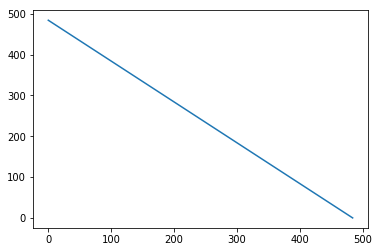

In [79]:
MAX=1000
MIN=-MAX

def plotting_hillclimber(fitness_function):
    data = []
    
    # Create and evaluate starting point
    x, y = random.randint(MIN, MAX), random.randint(MIN, MAX)
    fitness = fitness_function(x, y)
    data += [fitness]
    iterations = 0
    
    # Stop once we have found an optimal solution
    while fitness > 0:
        iterations += 1
        # Move to first neighbour with a better fitness 
        for (nextx, nexty) in neighbours(x,y):
            new_fitness = fitness_function(nextx, nexty)
            if new_fitness < fitness:
                x, y = nextx, nexty
                fitness = new_fitness
                data += [fitness]
                break

    print("Found optimum after %d iterations at %d, %d" % (iterations, x, y))
    return data
    
data = plotting_hillclimber(get_fitness)

import matplotlib.pyplot as plt
fig = plt.figure()
ax = plt.axes()

x = range(len(data))
ax.plot(x, data);


This is gradient is the result of an ideal fitness landscape. In practice, we won't always have such a nice gradient. In particular, our hillclimber only works well as long as there is at least one neighbour that has a better fitness value. What if we reach a point where _none_ of the neighbours actually has a better fitness value? Consider the following variant of our example `test_me` program:

In [ ]:
def test_me2(x, y):
    if x == 2*(y+1):
        return True 
    else:
        return False   

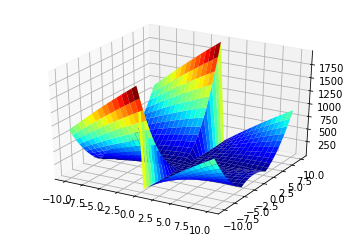

In [78]:
from mpl_toolkits.mplot3d import Axes3D
from math import exp, tan

x = np.outer(np.linspace(-10, 10, 30), np.ones(30))
y = x.copy().T
z = abs(x*x - y*y * (x % 20))
    

fig = plt.figure()
ax = plt.axes(projection='3d')

ax.plot_surface(x, y, z, cmap=plt.cm.jet, rstride=1, cstride=1, linewidth=0)


Suppose we have this kind of fitness landscape. We will just use a simulated fitness function for this:

In [80]:
def bad_fitness(x, y):
    # Simulated bad fitness landscape
    fitness = abs(x*x - y*y * (x % 20))
    return fitness

Running our hillclimber with this fitness function is not a good idea, because it might never terminate. Suppose we've reached a point where all neighbours have the same or a worse fitness value. The hillclimber can move no where and is stuck there forever! Such a point in the search landscape is called a *local optimum*. If one reaches such a point, the easiest way out is to give up and restart from a new random point. This is what we will do in our hillclimber with *random restarts*. 

In [82]:
def restarting_hillclimber(fitness_function):
    data = []
    
    # Create and evaluate starting point
    x, y = random.randint(MIN, MAX), random.randint(MIN, MAX)
    fitness = fitness_function(x, y)
    data += [fitness]
    print("Initial value: %d, %d at fitness %.4f" %(x, y, fitness))
    iterations = 0
    
    # Stop once we have found an optimal solution
    while fitness > 0:
        changed = False
        iterations += 1
        # Move to first neighbour with a better fitness 
        for (nextx, nexty) in neighbours(x,y):
            new_fitness = fitness_function(nextx, nexty)
            if new_fitness < fitness:
                x, y = nextx, nexty
                fitness = new_fitness
                data += [fitness]
                changed = True
                break
        if not changed:
            x, y = random.randint(MIN, MAX), random.randint(MIN, MAX)
            fitness = fitness_function(x, y)
            data += [fitness]

    print("Found optimum after %d iterations at %d, %d" % (iterations, x, y))
    return data

The change is trivial: We simply keep track whether any movement has occurred with a boolean flag, and if we did not move to any of the neighbours, we pick a new random starting position. We also made the hillclimber parameterizable with fitness functions. Let's try it out with our `bad_fitness` and plot the resulting fitness values we observe:

Initial value: -217, 318 at fitness 256283.0000
Found optimum after 147 iterations at 921, -921


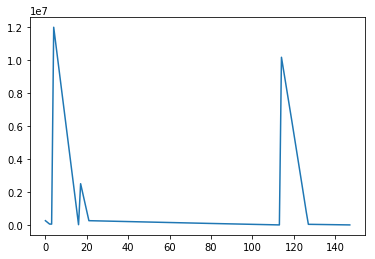

In [86]:
MAX=1000
MIN=-MAX

data = restarting_hillclimber(bad_fitness)

import matplotlib.pyplot as plt
fig = plt.figure()
ax = plt.axes()

x = range(len(data))
ax.plot(x, data);


Run the example a couple of times. Sometimes, we are lucky and there is a gradient that takes is straight to an optimal solution. But sometimes you'll see restarts throughout the search before reaching an optimal value.

We restricted initial values of `x` and `y` to  rather small range of `[MIN, MAX]`. This is a common trick in test generation, as in *most* cases solutions tend to consist of small values, and using small values to start the search makes the search quicker in many cases. However, what if the solution we need is at a completely different place in our search space? Our bias towards smaller solutions would mean that the hillclimber would take very long to find the solution, and given a fixed search budget it would thus be less likely to actually find a solution. To see what effects this would have, we could simple replace the `1000` with, say, `1000000` or more. We can play around with the range to see the performance we get for our simple search problems.

In [92]:
MAX =  100000
MIN = -MAX

import time
start = time.process_time()
restarting_hillclimber(get_fitness)
duration = time.process_time() - start
print("Search time: %.2fs" % duration)

Initial value: 27685, -30749 at fitness 89181.0000
Found optimum after 89181 iterations at -61496, -30749
Search time: 0.63s


 In most cases the search now will take extremely long until a solution is found --- much longer than we are prepared to wait for such a simple example function! How is this ever going to work on "real" examples? Not to imagine if there were even more parameters!

## Testing a More Complex Program

Let's turn to a slightly more complex program: The CGI decoder you already know from chapter TODO. 

In [29]:
def cgi_decode(s):
    """Decode the CGI-encoded string `s`:
       * replace "+" by " "
       * replace "%xx" by the character with hex number xx.
       Return the decoded string.  Raise `ValueError` for invalid inputs."""

    # Mapping of hex digits to their integer values
    hex_values = {
        '0': 0, '1': 1, '2': 2, '3': 3, '4': 4,
        '5': 5, '6': 6, '7': 7, '8': 8, '9': 9,
        'a': 10, 'b': 11, 'c': 12, 'd': 13, 'e': 14, 'f': 15,
        'A': 10, 'B': 11, 'C': 12, 'D': 13, 'E': 14, 'F': 15,
    }

    t = ""
    i = 0
    while i < len(s):
        c = s[i]
        if c == '+':
            t += ' '
        elif c == '%':
            digit_high, digit_low = s[i + 1], s[i + 2]
            i += 2
            if digit_high in hex_values and digit_low in hex_values:
                v = hex_values[digit_high] * 16 + hex_values[digit_low]
                t += chr(v)
            else:
                raise ValueError("Invalid encoding")
        else:
            t += c
        i += 1
    return t


### CGI Decoder as a Search Problem

The `cgi_decode` function has one input of type string, and one possible way to define the neighbourhood of a string is by all possible strings that have an edit distance of 1. For example, string `test` would have two neighbours for each character:

- `uest`
- `tfst`
- `tett`
- `tesu`
- `sest`
- `tdst`
- `tert`
- `tess`

In addition, prepending any character or appending any character would also have an edit distance of 1 and could be considered neighbours. To keep things simple, let's keep the length of our input strings fixed to a reasonable value (e.g. 10). In this case, each individual has 20 neighbours (i.e., each character has two neighbours).

Let's implement a new `neighbours` function that produces these neighbouring strings:

In [38]:
def neighbour_strings(x):
    n = []
    for pos in range(len(x)):
      c = ord(x[pos])
      if c < 127:
        n += [ x[:pos] + chr(c + 1) + x[pos + 1:] ]
      if c > 20:
        n += [ x[:pos] + chr(c - 1) + x[pos + 1:] ]
    return n

The `neighbour_strings` function gets the numerical value of each character in the input string, and creates a new string with the character replaced with the preceding and succeeding characters in the alphabet. To start with, we only consider printable ASCII characters, which are in the range 20--127.

In [39]:
print(neighbour_strings("Hello"))

['Iello', 'Gello', 'Hfllo', 'Hdllo', 'Hemlo', 'Heklo', 'Helmo', 'Helko', 'Hellp', 'Helln']


Thus we have defined the search space for the `cgi_decode` function. The next ingredient to searching for individuals in this search space is a fitness function.

### Branch Distances

The `test_me` function consisted of a single if-condition, in which two integer numbers were compared. In the `cgi_decode` function we have three if-conditions and one while loop, and they all compare characters. Fortunately, as we have already seen, we can treat characters like numbers, so we can use the same distance estimate we used in the `test_me` example. However, there are also two conditions which check whether a character is contained in a set, e.g. `digit_high in hex_values`. How close is a value to being contained in the set? An obvious solution would be to consider the distance to the closes value in the set as the estimate.

In [97]:
def distance_character(target, values):
    minimum = sys.maxsize
    for elem in values:
        distance = abs(target - elem)
        if distance < minimum:
            minimum = distance
    return minimum

print(distance_set(10, [1, 5, 12, 100]))
print(distance_set(10, [0, 50, 80, 200]))


2
10


A further simplification we have made so far was to assume that we would always want conditions to evaluate to true. In practice, we might want to have if-conditions evaluate to false just as well. Thus, each if-condition actually has two distance estimates, one to estimate how close it is to being true, and one how close it is to being false. If the condition is true, then the true distance is 0; if the condition is false, then the false distance is 0. That is, in a comparison `a == b`, if `a` is smaller than `b`, then the false distance of is `0` by definition. 

What is the distance of `a == b` being false when `a` equals `b`? Any change to either `a` or `b` would make the condition evaluate to false, so we can define the distance simply as 1.

More generally, there can be other types of comparisons, for example using relational operators. Consider the loop condition in `cgi_decode`: `i < len(s)`, i.e., it uses a less-than comparison operator. It is quite straight forward to extend our notion of branch distance to cover different types of comparisons, and to calculate true and false distances.  The following table shows how to calculate the distance for different types of comparisons:

| Condition | Distance True | Distance False |
| ------------- |:-------------:| -----:|
| a == b      | abs(a - b) | 1 |
| a != b      | 1          | abs(a - b) |
| a < b       | b - a + 1  | a - b      |
| a <= b      | b - a      | a - b + 1  |
| a > b       | a - b + 1  | b - a      |


Note that several of the calculations add a constant `1`. The reason for this is quite simple: Suppose we want to have `a < b` evaluate to true, and let `a = 27` and `b = 27`. The condition is not true, but simply taking the difference would give us a result of `0`. To avoid this, we have to add a constant value. It is not important whether this value is `1` -- any positive constant works.

### Dealing with Complex Conditions

In the `cgi_decode` function, we can also find a somewhat more complex predicate which consists of several comparisons:

`
if digit_high in hex_values and digit_low in hex_values:
`

In principle, the branch distance is defined such that the distance to make a conjunction `A and B` true equals the sum of the branch distances for `A` and `B`, as both of the two conditions would need to be true. Similarly, the branch distance to make `A or B` true would be the minimum of the two branch distances of `A` and `B`, as it suffices if one of the two conditions is true to make the entire expression true. 

However, it is not as easy as that in practice: Predicates can consist of nested conditions and negations, and one would need to convert the expression to canonical form before being able to apply this calculation. Furthermore, most modern programming languages use *short-circuit evaluation*: If there is a condition `A or B`, and `A` is true, then `B` is never evaluated. If `B` is an expression with side-effects, then by calculating the branch distance of `B` even though short-circuit evaluation would avoid its execution, we would potentially be changing the program behavior (by invoking the side-effect that would in normal behavior not be executed), and that is not acceptable.


Furthermore, what if the branching condition has side-effects? For example, suppose that the branching condition were `x == 2 * foo(y)`, where `foo` is a function that takes an integer as input. Naively instrumenting would lead to the following code:

```
    distance = abs(x - 2 * foo(y))
	if x == 2 * foo(y):
	...
```

Thus, the instrumentation would lead to `foo` being executed *twice*. Suppose `foo` changes the state of the system (e.g., by printing something, accessing the filesystem, changing some state variables, etc.), then clearly invoking `foo` a second time is a bad idea. One way to overcome this problem is to transform the conditions, rather than adding tracing calls. For example, one can create temporary variables that hold the values necessary for the distance calculation and then use these in the branching condition:

```
	tmp1 = x
	tmp2 = 2 * foo(y)
	distance = abs(tmp1, tmp2)
	if tmp1 == tmp2:
	...
```

Besides these issues, the approach of adding a global variable and method call to the program seems like a rather clumsy approach --- surely we cannot start thinking about every branch in our program on its own and instrument the program we want to test manually, in particular if programs have multiple branches like the `cgi_decode` function. Rather, we should be looking at how to _automatically_ instrument programs to contain the necessary added statements such that we can calculate fitness values.

### Instrumentation for atomic conditions

An alternative approach to using the global and temporary variables is to replace the actual comparison with a call to a helper function, where the original expressions are evaluated as arguments, and the operator is an additional argument. Assume a `evaluate_condition` function which takes four parameters: `num` is a unique id that identifies the condition; `op` is the operator of the comparison; `lhs` and `rhs` are the operands. The function calculates two distances for the condition: The distance to the condition evaluating to true, and the distance to the condition evaluating to false. One of the two outcomes will always be true, and thus one of them will always have distance `0`. The function returns true or false, depending on which distance is `0`. That means, the example expression 

```
    if x == 2 * foo(y)
```
    
would be replaced by 

```
    if evaluate_condition(0, "==", x, 2 * foo(y))
```

such that the arguments are only evaluated once, and side-effects are thus handled correctly. Here is how the `evaluate_condition` function looks like:

TODO: Explain global map instead of global variable
TODO: Point out that `BranchPredicate` needs to return true or false


In [101]:
def evaluate_condition(num, op, lhs, rhs):
    distance_true  = 0
    distance_false = 0
    if op == "Eq":
        if lhs == rhs:
            distance_false = 1
        else:
            distance_true = abs(lhs - rhs)

    # ... code for other types of conditions
    
    if distance_true == 0:
        return True
    else:
        return False

Note that we are initializing `distance_true` and `distance_false` with `0`. Thus, if `lhs` equals `rhs`, then the variable `distance_true` remains 0, and vice versa.

In [102]:
evaluate_condition(1, "Eq", 10, 20)

False

In [103]:
evaluate_condition(2, "Eq", 20, 20)

True

What the `evaluate_condition` function does not do yet is store the distances observed. Obviously, we will need to store the values somewhere so that we can access it from our fitness function. Since the `cgi_decode` program consists of several conditions, and for each condition we might be interested in the true and the false distance, we simply use two global dictionaries, `distances_true` and `distances_false`:

In [136]:
def update_maps(num, d_true, d_false):
    global distances_true, distances_false
    
    if num in distances_true.keys():
        distances_true[num]  = min(distances_true[num], d_true)
    else:
        distances_true[num]  = d_true

    if num in distances_false.keys():
        distances_false[num] = min(distances_false[num], d_false)
    else:
        distances_false[num] = d_false


We simply need to call this function from within `evaluate_condition`. Let's also add the calculation of distance for the `in` operator and the `<` comparison. Furthermore, `cgi_decode` actually compares characters and numbers. To make sure we use the correct types, we first have to convert the characters to numbers to calculate the distances. This is done using Python's `ord` function.

In [152]:
def evaluate_condition(num, op, lhs, rhs):
    distance_true  = 0
    distance_false = 0
    
    # Make sure the distance can be calculated on number and character comparisons
    if type(lhs) == str:
        lhs = ord(lhs)
    if type(rhs) == str:
        rhs = ord(rhs)
    
    if op == "Eq":
        if lhs == rhs:
            distance_false = 1
        else:
            distance_true = abs(lhs - rhs)

    elif op == "Lt":
        if lhs < rhs:
            distance_false = rhs - lhs
        else:
            distance_true  = lhs - rhs + 1
    # ...
    # handle other comparison operators
    # ...
    
    elif op == "In":
        minimum = sys.maxsize
        for elem in rhs.keys():
            distance = abs(lhs - ord(elem))
            if distance < minimum:
                minimum = distance

        distance_true = minimum
        if distance_true == 0:
            distance_false = 1

    update_maps(num, distance_true, distance_false)
            
    if distance_true == 0:
        return True
    else:
        return False

The following shows the instrumentation of the conjunction from `cgi_decode`. There are two calls to `evaluate_condition` corresponding to the two conditions, and the `and` with which they are conjoined ensures that the original short-circuiting behavior is preserved:

`
if (evaluate_condition(4, 'In', digit_high, hex_values) and evaluate_condition(5, 'In', digit_low, hex_values))
`

Of course we would like to automatically produce this instrumented varion.

TODO: Remainder of complex conditions. Exercise?

### Instrumenting source code automatically

Replacing comparisons automatically is quite easy on the abstract syntax tree (AST) of the program. In the AST, a comparison will typically be a tree node with an operator attribute and two children for the left-hand and right-hand operators. To replace such comparisons with a call to `evaluate_condition` one simply needs to replace the comparison node in the AST with a function call node, and this is what the `BranchDistanceTransformation` function does using a NodeTransformer:


In [146]:
import ast

class BranchTransformer(ast.NodeTransformer):

    branch_num = 0

    def visit_Compare(self, node):
        if node.ops[0] in [ast.Is, ast.IsNot, ast.In, ast.NotIn]:
            return node

        self.branch_num += 1
        return ast.Call(func = ast.Name("evaluate_condition", ast.Load()),
                        args = [ast.Num(self.branch_num),
                                ast.Str(node.ops[0].__class__.__name__),
                                node.left,
                                node.comparators[0]],
                        keywords=[],
                        starargs=None,
                        kwargs=None)

The `BranchDistanceTransformer` parses a target Python program using the built-in parser `ast.parse`, which returns the AST. Python provides API to traverse and modify this AST. To replace the comparison with a function call we use an `ast.NodeTransformer`, which uses the visitor pattern where there is one `visit_*` function for each type of node in the AST. As we are interested in replacing comparisons, we override `visit_Compare`, where instead of the original comparison node we return a new node of type `ast.Func`, which is a function call node. The first parameter of this node is the name of the function `evaluate_condition`), and the arguments are the four arguments that our `evaluate_condition` function expects: Number of branch (for which we keep a count in `branch_num`), the operator (for which we simply use the class name), the left-hand side, and the right-hand side. Note that Python allows comparisons of multiple expressions (e.g. `1 < x < 10`); to keep the code simple we only deal with individual comparisons here, but it would be straight forward to extend the code by treating each comparison with an individual call to `evaluate_condition`.


The following code parses the source code of the `cgi_decode` function to an AST, then transforms it, and prints it out again (using the `to_source` function from the `astor` library):

In [147]:
import inspect
import ast
from astor import to_source

source = inspect.getsource(cgi_decode)
node = ast.parse(source)
BranchTransformer().visit(node)

# Make sure the line numbers are ok before printing
node = ast.fix_missing_locations(node)
print(to_source(node))

def cgi_decode(s):
    """Decode the CGI-encoded string `s`:
       * replace "+" by " "
       * replace "%xx" by the character with hex number xx.
       Return the decoded string.  Raise `ValueError` for invalid inputs."""
    hex_values = {'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6,
        '7': 7, '8': 8, '9': 9, 'a': 10, 'b': 11, 'c': 12, 'd': 13, 'e': 14,
        'f': 15, 'A': 10, 'B': 11, 'C': 12, 'D': 13, 'E': 14, 'F': 15}
    t = ''
    i = 0
    while evaluate_condition(1, 'Lt', i, len(s)):
        c = s[i]
        if evaluate_condition(2, 'Eq', c, '+'):
            t += ' '
        elif evaluate_condition(3, 'Eq', c, '%'):
            digit_high, digit_low = s[i + 1], s[i + 2]
            i += 2
            if evaluate_condition(4, 'In', digit_high, hex_values
                ) and evaluate_condition(5, 'In', digit_low, hex_values):
                v = hex_values[digit_high] * 16 + hex_values[digit_low]
                t += chr(v)
            else:
             

To calculate a fitness value with the instrumented version, we need to compile the instrumented AST, and then create a new module

TODO: Can we use this to hook it into the current module? Then we wouldn't need the hack of copying evaluate_condition over:
import sys
current_module = sys.modules[__name__]

In [153]:
def get_instrumented_function(f):
    source = inspect.getsource(f)
    node = ast.parse(source)
    node = BranchTransformer().visit(node)

    # Make sure the line numbers are ok so that it compiles
    node = ast.fix_missing_locations(node)    

    # Create a new module in which to place the instrumented function
    import types
    module = types.ModuleType("cgi_decode_instrumented")
    code = compile(node, filename="<ast>", mode="exec")    
    exec(code, module.__dict__)
    
    # Add a reference to the instrumented function so we don't have to
    # deal with namespaces and imports
    module.evaluate_condition = evaluate_condition
    return module.cgi_decode
    
# Set up the global maps
distances_true = {}
distances_false = {}

# Create instrumented function
cgi_decode_instrumented = get_instrumented_function(cgi_decode)

# Outputs should be the same
print("Original    : %s" % cgi_decode("Hello+Reader"))
print("Instrumented: %s" % cgi_decode_instrumented("Hello+Reader"))

print(distances_true)
print(distances_false)

Original    : Hello Reader
Instrumented: Hello Reader
{1: 0, 2: 0, 3: 35}
{1: 0, 2: 0, 3: 0}


As we can see from the `distances_true` and `distances_false` maps, conditions 1 and 2 have evaluated to true and to false, whereas condition 3 has only evaluated to false. This is as expected, since the while-loop was entered and left, and there was one white space but no `%`-character in the input string.

### Fitness function to create valid hexadecimal inputs

As an example, let's take as objective to test the part of `cgi_decode` that decodes valid hexadecimal codes. This means that we want to make condition 1 true, 2 false, 3 true, and 4 true. To represent such a path, we can simply sum up the branch distances for exactly these branches. However, there is a potential issue with simply summing up branch distances: If the distance for one condition depends on a comparison of very large values and the distance calculation for another condition depends on small values, then an improvement of the large values would very likely lead to a better fitness improvement, and thus bias the search. To avoid this, we need to *normalize* branch distances before adding them up.

A normalisation function for a range `[a, b]` takes a number as input and returns a value that is `>=` and `<=`. The important thing about the function is that for any two numbers `x` and `y` the ordering needs to be preserved by the normalisation. That is, if `x<y` then it must also hold that `normalize(x) < normalize(y)`. There are many different functions that could achieve this result; a simple one is `normalize(x) = x/(x+k)`: It is computationally cheap, and will normalise any positive value in the range `[0,1]` (to change this to `[0,b]` one would just need to multiply by `b`). If we use this normalisation function, we know our `K` exactly: it is `1.0`. The function assumes that the value to be normalised is positive. The value of the factor `k` defines the steepness of the curve. For example, for `k=1` (which is a good default value) the curve is very steep, with values quickly approaching, but never reaching, `1`.

In [161]:
def normalize(x):
    return x/(1.0+x)

Using this normalization function, we can calculate a fitness value by running the instrumented program under test, and then adding up the normalized values of the relevant branches. However, not every if statement will be executed by every test case. What is the branch distance for a branch that wasn't even executed? We need to make sure that the branch distance for branches that weren't even executed is higher than any of the branch distances observed during execution. If we use normalization, then we know this maximum value is 1. Thus, the fitness function could look like this:

In [168]:
def get_fitness(x):
    global distances_true, distances_false
    distances_true = {}
    distances_false = {}
    try:
        cgi_decode_instrumented(x)
    except:
        pass
    fitness = 0.0
    for branch in [1,3,4,5]:
        if branch in distances_true:
            fitness += normalize(distances_true[branch])
        else:
            fitness += 1.0
                                 
    for branch in [2]:
        if branch in distances_false:
            fitness += normalize(distances_false[branch])
        else:
            fitness += 1.0
    
    return fitness

To see our instrumentation in action, let's calculate fitness values for a couple of example inputs, progressively getting closer to the target.

In [171]:
# Empty string does not even enter the loop
print(get_fitness(""))

# String contains no percentage character
print(get_fitness("Hello+Reader"))

# String contains a percentage character, but no valid hex char
print(get_fitness("%UU"))

# String contains a percentage character, but only one valid hex char
print(get_fitness("%AU"))

# String contains a percentage character and two valid hex chars
print(get_fitness("%AA"))

4.5
2.9722222222222223
1.9230769230769231
0.9230769230769231
0.0


### Hillclimbing valid hexadecimal inputs

We have now defined the search space through our `neighbour_strings` function, and we have derived a new fitness function, so before we can apply the hillclimber to the problem of finding strings that contain valid 2 digit hex codes, the only remaining point is to derive a random starting point, which you've already done previously in chapter TODO:

In [172]:
def random_string(l):
    s = ""
    for i in range(l):
        random_character = chr(random.randrange(32, 127))
        s = s + random_character
    return s

Now we can put it all together and use the identical hillclimbing algorithm again, and just make it generate random strings instead of numbers, and use the new fitness function:

In [175]:
def hillclimb_cgi():
    x = random_string(10)
    fitness = get_fitness(x)
    print("Initial input: %s at fitness %.4f" %(x, fitness))                

    while fitness > 0:
        changed = False
        for (nextx) in neighbour_strings(x):
            new_fitness = get_fitness(nextx)
            if new_fitness < fitness:
                x = nextx
                fitness = new_fitness
                changed = True
                print("New value: %s at fitness %.4f" %(x, fitness))                
                break

        # Random restart if necessary
        if not changed:
            x = random_string(10)
            fitness = get_fitness(x)

    print("Optimum at %s, fitness %.4f" % (x, fitness))
    
hillclimb_cgi()

Initial input: c`$(AEB_04 at fitness 2.5000
New value: c`%(AEB_04 at fitness 1.8889
New value: c`%)AEB_04 at fitness 1.8750
New value: c`%*AEB_04 at fitness 1.8571
New value: c`%+AEB_04 at fitness 1.8333
New value: c`%,AEB_04 at fitness 1.8000
New value: c`%-AEB_04 at fitness 1.7500
New value: c`%.AEB_04 at fitness 1.6667
New value: c`%/AEB_04 at fitness 1.5000
New value: c`%0AEB_04 at fitness 0.0000
Optimum at c`%0AEB_04, fitness 0.0000


Run the hillclimber a couple of times to see it generate strings with valid hex characters. Sometimes it only takes a couple of steps, sometimes it takes longer, but at the end it always solves the problem and generates the string we want to have.

TODO Exercises:
- Target different branch

In [ ]:
def random_string(l):
    s = ""
    for i in range(l):
        random_character = chr(random.randrange(32, 127))
        s = s + random_character
    return s

In [ ]:
def flip_random_character(s):
    """Returns s with a random bit flipped in a random position"""
    if s == "":
        return s

    pos = random.randint(0, len(s) - 1)
    new_c = random_character = chr(random.randrange(32, 127))
    return s[:pos] + new_c + s[pos + 1:]

In [ ]:
def pattern_search(text, pos, direction, fitness):
    print("Current pattern search: position %d of %s, direction %d, fitness %.4f" % (pos, text, direction, fitness))

    new_c = chr((ord(text[pos]) + 2 * direction) % 256)
    new_text = text[:pos] + new_c + text[pos + 1:]
    new_fitness = get_fitness(new_text)
    print("Trying %d: %s / %.4f" % (2*direction, new_text, new_fitness))
    if new_fitness < fitness:
        print("New value: %s at fitness %.4f" % (new_text, fitness))
        return pattern_search(new_text, pos, 2 * direction, new_fitness)
    else:
        print("Restoring value: %s at fitness %.4f" % (text, fitness))
        return (text, fitness)

In [ ]:
x = random_string(10)
fitness = get_fitness(x)
print("Initial value: %s at fitness %.4f" % (x, fitness))

while fitness > 0:
    changed = True
    while changed:
        changed = False
        # Apply search on each character
        for pos in range(len(x)):
            print("Current parameter: %d" % pos)

            (new_value, new_fitness) = pattern_search(x, pos, +1, fitness)
            (new_value, new_fitness) = pattern_search(new_value, pos, -1, new_fitness)
            if new_fitness < fitness:
              x, fitness = new_value, new_fitness
              changed = True

            print("New value after pattern search: %s at fitness %.4f" %(x, fitness))
    if fitness > 0:
        x = random_string(10)
        print("Restarting with %s " % x)
        fitness = get_fitness(x)

print("Optimum at %s, fitness %.4f" % (x, fitness))

### The Alternating Variable Method

TODO: Move it to exercises

## Evolutionary Search

TODO: Apply on same problem, just replacing algorithm

Hillclimbing works well, if the neighbourhood is reasonably small. This was the case so far in the `cgi_decode` example because we limited ourselves to a fixed number of characters (10) and limited the character range to 256. But imagine what happens if we are not looking for ASCII characters, but  UTF-16 unicode characters? These are not allowed in URLs really, but let's see what happens if we change our search space:

In [ ]:
def random_string(l):
    s = ""
    for i in range(l):
        random_character = chr(random.randrange(0, 65536))
        s = s + random_character
    return s

def neighbours(x):
    n = []
    for pos in range(len(x)):
      c = ord(x[pos])
      if c < 65536:
        n += [ x[:pos] + chr(c + 1) + x[pos + 1:] ]
      if c > 0:
        n += [ x[:pos] + chr(c - 1) + x[pos + 1:] ]

    return n

### Global search

The hillclimber explores the local neighbourhood of an individual in each step of the search, and if the neighbourhood is too large, then this takes too long. An alternative strategy is to not restrict the search to the local neighbourhood, but to search the search space *globally*. That is, the search algorithm is allowed to make larger steps around the search space. A simple modification of the hillclimber converts it from a local to a global search algorithm: Instead of looking at all the immediate neighbours, the individual is *mutated* in a way that allows larger modifications. Then, the resulting offspring individual is compared to its parent, and the better of the two is the new point in the search space, and used for the next iteration of mutation. This is called "randomized hillclimbing":

In [ ]:
x = random_string(10)
fitness = get_fitness(x)
print("Initial value: %s at fitness %.4f" % (x, fitness))
while fitness > 0:
    mutated = flip_random_character(x)
    new_fitness = get_fitness(mutated)
    if new_fitness <= fitness:
        x = mutated
        fitness = new_fitness
        print("New value: %s at fitness %.4f" %(x, fitness))


print("Optimum at %s, fitness %.4f" % (x, fitness))

TODO: Explain importance of `<=` instead of `<`.

TODO: Explain that this is also called "1+1 Evolutionary Algorithm". What is an evolutionary algorithm?

### Genetic Algorithms

General concept: Population, selection, crossover, mutation

In [ ]:
def selection(population, tournament_size):
    selected = random.choice(population)
    champion_fitness = fitness(selected)
    competition = random.sample(population, tournament_size)
    for competitor in competition:
        challenger_fitness = fitness(competitor)
        if challenger_fitness < champion_fitness:
            selected = competitor
            champion_fitness = challenger_fitness

    # Return a copy of the selected individual
    return selected[:]

Crossover:

In [ ]:
def crossover(parent1, parent2):
    pos = random.randint(0,len(parent1))

    offspring1 = parent1[:pos] + parent2[pos:]
    offspring2 = parent2[:pos] + parent1[pos:]

    return (offspring1, offspring2)

General algorithm

In [ ]:
POPULATION_SIZE=20
generation = 0
best_fitness = sys.maxint

population = [random_string(4) for i in range(POPULATION_SIZE)]
population.sort(key=lambda individual: fitness(individual))

while best_fitness > 0 and generation < 5000:

    best_fitness = fitness(population[0])
    print("Best fitness at generation %d: %.10f" % (generation, best_fitness))
    generation += 1

    new_population = []
    while len(new_population) < len(population):
        # selection
        offspring1 = selection(population, 5)
        offspring2 = selection(population, 5)

        # crossover
        if random.random() < 0.7:
            (offspring1, offspring2) = crossover(offspring1, offspring2)

        # mutation
        if random.random() < 0.1:
            offspring1 = mutate(offspring1)

        if random.random() < 0.1:
            offspring2 = mutate(offspring2)

        new_population.append(offspring1)
        new_population.append(offspring2)

    # Once full, the new population replaces the old one
    population = new_population

    # Sort population by fitness
    population.sort(key=lambda individual: fitness(individual))

print("Best individual: %s, fitness %.10f" % (population[0], fitness(population[0])))

## Lessons Learned

* _Lesson one_
* _Lesson two_
* _Lesson three_

## Next Steps

_Link to subsequent chapters (notebooks) here, as in:_

* [use _mutations_ on existing inputs to get more valid inputs](MutationFuzzer.ipynb)
* [use _grammars_ (i.e., a specification of the input format) to get even more valid inputs](Grammars.ipynb)
* [reduce _failing inputs_ for efficient debugging](Reducer.ipynb)


## Background

_Cite relevant works in the literature and put them into context, as in:_

The idea of ensuring that each expansion in the grammar is used at least once goes back to Burkhardt \cite{Burkhardt1967}, to be later rediscovered by Paul Purdom \cite{Purdom1972}.

## Exercises

_Close the chapter with a few exercises such that people have things to do.  To make the solutions hidden (to be revealed by the user), have them start with_

```markdown
**Solution.**
```

_Your solution can then extend up to the next title (i.e., any markdown cell starting with `#`)._

_Running `make metadata` will automatically add metadata to the cells such that the cells will be hidden by default, and can be uncovered by the user.  The button will be introduced above the solution._

### Exercise 1: Simulated Annealing

TODO: Simulated Annealing

In [ ]:
# TODO

_Some more text for the exercise_

**Solution.** _Some text for the solution_

In [ ]:
def hillclimber():
    # Create and evaluate starting point
    x, y = random.randint(MIN, MAX), random.randint(MIN, MAX)
    fitness = get_fitness(x, y)
    print("Initial value: %d, %d at fitness %.4f" %(x, y, fitness))
    iterations = 0
    
    # Stop once we have found an optimal solution
    while fitness > 0:
        iterations += 1
        # Move to first neighbour with a better fitness 
        for (nextx, nexty) in neighbours(x,y):
            new_fitness = get_fitness(nextx, nexty)
            if new_fitness < fitness:
                x, y = nextx, nexty
                fitness = new_fitness
                changed = True
                print("New value: %d, %d at fitness %.4f" %(x, y, fitness))
                break

    print("Found optimum after %d iterations at %d, %d" % (iterations, x, y))
    
hillclimber()

_Some more text for the solution_

### Exercise 2: Alternating Variable Method

_Text of the exercise_

**Solution.** _Solution for the exercise_